In [20]:
# Imports 
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import random
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
import seaborn as sns
from lifelines.plotting import plot_lifetimes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [2]:
# dataset
df = pd.read_csv('dataset_vraissemblance.csv') 

**What is the Kaplan-Meier estimator?** <br>
<br>
The Kaplan-Meier (KM) estimator is a non-parametric statistic that estimates the survival function of time-to-event data. <br>
<br>
We note : <br>
- $t_i \space \text{a duration time} $
- $ d_i \space \text{number of events that happened at time} \space t_i$
- $n_i \space \text{number of individuals known to have survived up to time}$ <br>
Then, the survival function $S(t)$ is estimated with: $\displaystyle \prod_{i:t_i \le t} (1 - \frac{d_i}{n_i})$. <br>
<br>

Here, our variables are doubly truncated. On the one hand, we can carry out the observation if and only if the individual died before June 2023. Secondly, we consider the survival period from the date on which the life annuity contract was signed.  <br>Let's give a few notations :
<br> <br>
$T_i$ is the lifetime of the seller, $T_{i,birth}$ the date of birth of seller $i$, $T_c$ the date of the contract signature and $T_{end}$ 1 June 2023. <br>
People $i$ is included in the sample if and only if: <br> $$ T_{i,birth} + T_i \le T_{end} \space \space \text{and} \space \space T_{i,birth} + T_i \ge T_c$$.

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_4864/2205508695.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time3, survival_prob3, conf_int3 = kaplan_meier_estimator([True]*df[df['sexe_femme']==np.float(1)].shape[0],
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_4864/2205508695.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

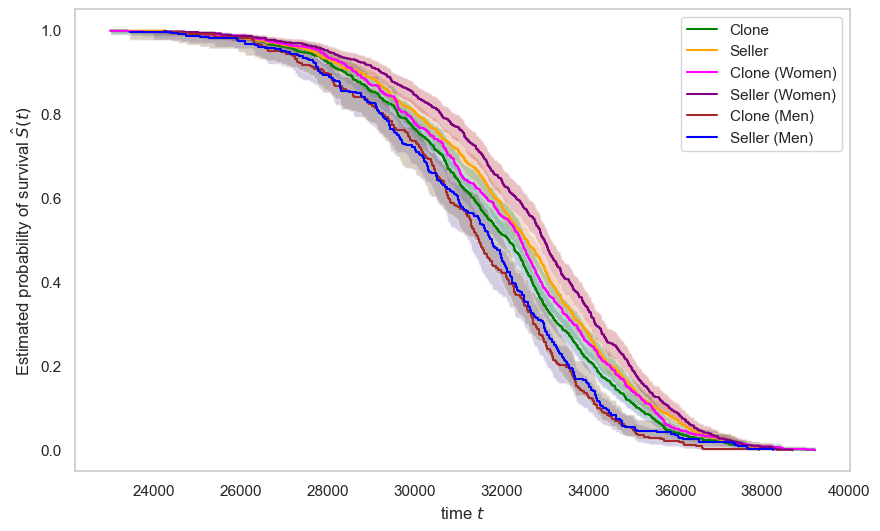

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

time1, survival_prob1, conf_int1 = kaplan_meier_estimator([True]*df.shape[0], df["Td_clone"], conf_type="log-log")
time2, survival_prob2, conf_int2 = kaplan_meier_estimator([True]*df.shape[0], df["Td"], conf_type="log-log")
time3, survival_prob3, conf_int3 = kaplan_meier_estimator([True]*df[df['sexe_femme']==np.float(1)].shape[0], 
                                                          df[df['sexe_femme']==np.float(1)]["Td_clone"], 
                                                          conf_type="log-log")
time33, survival_prob33, conf_int33 = kaplan_meier_estimator([True]*df[df['sexe_femme']==np.float(1)].shape[0], 
                                                             df[df['sexe_femme']==np.float(1)]["Td"], 
                                                            conf_type="log-log")
time4, survival_prob4, conf_int4 = kaplan_meier_estimator([True]*df[df['sexe_homme']==np.float(1)].shape[0], 
                                                          df[df['sexe_homme']==np.float(1)]["Td_clone"], 
                                                          conf_type="log-log")
time44, survival_prob44, conf_int44 = kaplan_meier_estimator([True]*df[df['sexe_homme']==np.float(1)].shape[0], 
                                                             df[df['sexe_homme']==np.float(1)]["Td"], 
                                                            conf_type="log-log")

plt.step(time1, survival_prob1, where="post", label = "Clone", color = 'green')
plt.fill_between(time1, conf_int1[0], conf_int1[1], alpha=0.35, step="post")

plt.step(time2, survival_prob2, where="post", label = "Seller", color = 'orange')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.35, step="post")

plt.step(time3, survival_prob3, where="post", label = "Clone (Women)", color = 'magenta')
plt.fill_between(time3, conf_int3[0], conf_int3[1], alpha=0.35, step="post")
plt.step(time33, survival_prob33, where="post", label = "Seller (Women)", color = 'purple')
plt.fill_between(time33, conf_int33[0], conf_int33[1], alpha=0.35, step="post")

plt.step(time4, survival_prob4, where="post", label = "Clone (Men)", color = 'brown')
plt.fill_between(time4, conf_int4[0], conf_int4[1], alpha=0.35, step="post")
plt.step(time44, survival_prob44, where="post", label = "Seller (Men)", color = 'blue')
plt.fill_between(time44, conf_int44[0], conf_int44[1], alpha=0.35, step="post")


plt.ylabel("Estimated probability of survival $\hat{S}(t)$")
plt.grid(False)
plt.xlabel("time $t$")
plt.legend()
plt.show()

## Taking into account left truncation

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/lifelines/plotting.py:727: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


Text(0.5, 0, 'Years from viager sold')

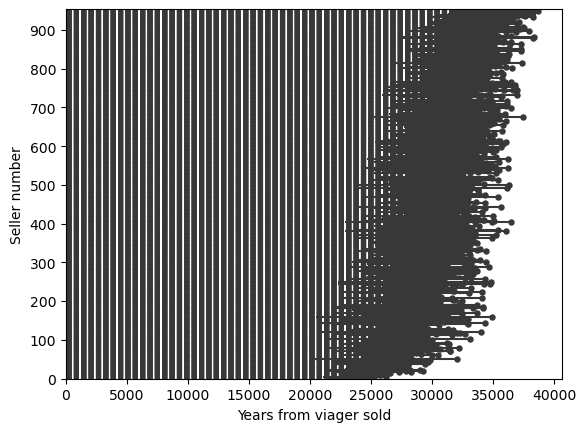

In [3]:
df['event'] = 1
plot_lifetimes(
    df["Td"],
    event_observed= df['event'],
    entry=df["Ts"],
    event_observed_color="#383838",
    event_censored_color="#383838",
    left_truncated=True,
)
plt.ylabel("Seller number")
plt.xlabel("Years from viager sold")

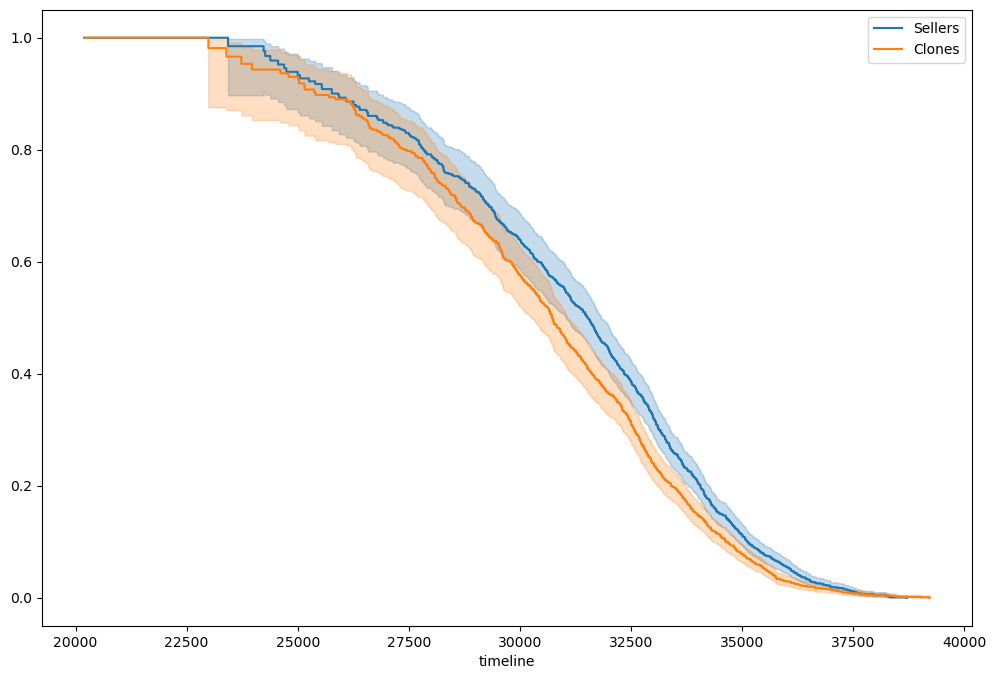

In [5]:
plt.figure(figsize= (12,8))
kmf_seller = KaplanMeierFitter()
kmf_seller.fit(df["Td"], event_observed=df["event"], entry=df["Ts"], label='Sellers')
kmf_seller.plot_survival_function()

kmf_clone = KaplanMeierFitter()
kmf_clone.fit(df["Td_clone"], event_observed=df["event"], entry=df["Ts_clone"], label='Clones')
kmf_clone.plot_survival_function()
plt.legend()
plt.show()

## Essayons de prédire Td à partir des données

In [16]:
columns = ['type_libre', 'sexe_homme', 'idf', 'etranger', 'une_tete', 'dec1', 
           'dec2', 'dec3', 'tau_birth','tau_contract', 'Td', 'Ts', 'sexe_femme']

FEATURES = ['type_libre', 'sexe_homme', 'idf','etranger', 'une_tete', 'dec1', 
            'dec2', 'dec3', 'tau_birth','tau_contract', 'Ts', 'sexe_femme']

TARGET = 'Td'

data = df[columns]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data[FEATURES], data[TARGET], test_size=0.3)
model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

def scoring(y_test, y_pred):
    y = np.array(y_test)
    n = len(y)
    if len(y) != len(y_test):
        print("error")
    else:
        value = 0 
        for i in list(range(n)):
            value += np.abs(y[i] - y_pred[i]) / 365
        value /= n
    return value

print(scoring(y_test,y_pred))

5.530852560736955
